# Testing Transformer performance on CIFAR10 challenge according to different channel size
Trying to make the Encoder_MultiheadedAttention.py work for the CIFAR 10 challenge. 


In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import math

#from Encoder_MultiheadedAttention import Encoder

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

cuda


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4921569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4921569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.4529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.2098039].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.3352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.2411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5..1.5].
Clipping input data to the valid 

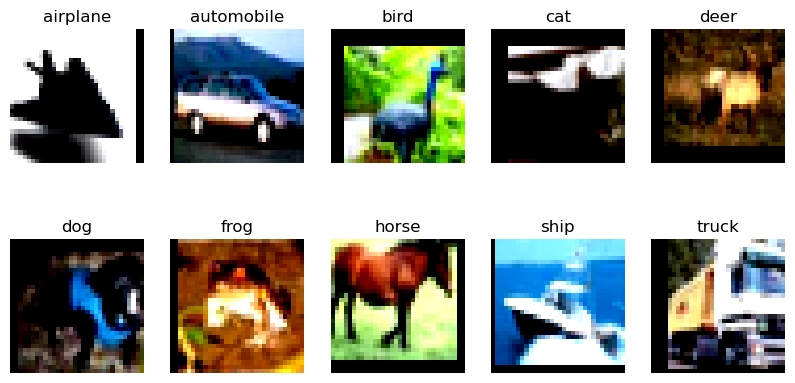

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
                                      ])
transform_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),])

batch_size = 128

# Download and load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create imbalanced traindataset
num_samples_per_class = {k:(k+1)*500 for k in range(10)}
class_to_indices = {cls: np.where(np.array(trainset.targets) == cls)[0] for cls in range(10)}
imbalanced_indices = []
for cls, count in num_samples_per_class.items():
    indices = class_to_indices[cls][:count]  # Select the first `count` samples
    imbalanced_indices.extend(indices)
imbalanced_trainset = Subset(trainset, imbalanced_indices)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

# get one image from each class
images = []
for i in range(10):
    for image, label in trainset:
        if label == i:
            images.append(image)
            break

# plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()

In [3]:
def validate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            #print("Output: ", outputs[12])
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #print("Total: ", total)
            correct += (predicted == labels).sum().item()
    return correct / total

def train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    acc_init = validate(model, testloader, device)
    print(f"Accuracy before Training: {acc_init}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader): 
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            preds = model(inputs)
            
            
            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")
        train_accuracy = validate(model, trainloader, device)
        print(f"Accuracy on train set: {train_accuracy}")
        accuracy = validate(model, testloader, device)
        print(f"Accuracy on test set: {accuracy}")

In [ ]:
"""transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,)),
    FlattenTransform()
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.25,)),
    FlattenTransform()
])

# Update the datasets with the new transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Update the dataloaders with the new datasets
trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)"""

In [4]:
class Attention(nn.Module): 
    def __init__(self, dim_1, dim_2): 
        super(Attention, self).__init__()
        self.K = nn.Linear(dim_1, dim_2, bias=False)
        self.Q = nn.Linear(dim_1, dim_2, bias=False)
        self.V = nn.Linear(dim_1, dim_2, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x): 
        #print("X: ", x.size())
        scores = self.K(x) @ self.Q(x).transpose(-2, -1)
        #print("scores: ", scores.size())
        att_weight = self.softmax(scores / np.sqrt(x.shape[-1]))
        #print("att_weight", att_weight.size())
        out = att_weight @ self.V(x)
        #print("out weight: ", out.size())
        return out

class MultiHeadAttention(nn.Module): 
    def __init__(self, dim_1, dim_2, num_heads): 
        super(MultiHeadAttention, self).__init__()
        self.heads = nn.ModuleList(Attention(dim_1, dim_2) for _ in range(num_heads))
        self.Z = nn.Linear(num_heads * dim_1, dim_1)

    def forward(self, x): 
        #print(x.size())
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        #print(out.size())
        return self.Z(out)
    
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, max_len=32):
        super(PositionalEncoding2D, self).__init__()
        pe = torch.zeros(d_model, max_len, max_len)
        pos_x = torch.arange(max_len).unsqueeze(1)
        pos_y = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe[:, :, 0::2] = torch.sin(pos_x * div_term).unsqueeze(1)
        pe[:, :, 1::2] = torch.cos(pos_y * div_term).unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :x.size(2), :x.size(3)]
    
class EncoderLayer(nn.Module):
    def __init__(self, dim_1, head_size, num_heads, ff_size): 
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(dim_1, head_size, num_heads)
        self.layer_norm = nn.LayerNorm(dim_1)
        self.ff = nn.Sequential(
            nn.Linear(dim_1, ff_size), 
            nn.GELU(), 
            nn.Linear(ff_size, dim_1)
        )  
    
    def forward(self, x): 
        out = x + self.mha(x)
        out = self.layer_norm(out)
        temp = out
        out = temp + self.ff(out)
        out = self.layer_norm(out)
        return out

class Encoder(nn.Module): 
    def __init__(self, dim, head_size, num_heads, ff_size, num_encoders, num_classes): 
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(EncoderLayer(dim_1=dim, head_size=head_size, num_heads=num_heads, ff_size=ff_size) for _ in range(num_encoders))
        self.pe = PositionalEncoding2D(dim, max_len=32)
        self.linear = nn.Linear(dim, num_classes)
    
    def forward(self, x): 
        x = x + self.pe(x)
        for layer in self.layers: 
            x = layer(x)
        #print("X size: ", x.size())
        x = x.mean(dim=1) 
        x = x.mean(dim=1)
        out = self.linear(x)
        #print("Out size: ", out.size())
        return self.linear(x)


In [5]:
# Get one image from the dataset
image, label = trainset[0]

dim_1 = image.size(dim=1)
dim_2 = image.size(dim=2)
K = nn.Linear(dim_1, dim_2, bias=False)
Q = nn.Linear(dim_1, dim_2, bias=False)
V = nn.Linear(dim_1, dim_2, bias=False)
softmax = nn.Softmax(dim=-1)

scores = K(image) @ Q(image)
att_weight = softmax(scores / np.sqrt(image.shape[-1]))
out = att_weight @ V(image)


channel, x, y = out.size()
pos_x = torch.arange(x, device=out.device)
pos_y = torch.arange(y, device=out.device)
# Einfach erstmal zwei for schleifen die über alle channel alles iterieren? 

div_term_x = torch.exp(torch.arange(0, x, 2).float() * (-math.log(10000.0) / x))
div_term_y = torch.exp(torch.arange(0, y, 2).float() * (-math.log(10000.0) / y))

sin_inp_x = torch.sin(torch.einsum("i,j->ij", pos_x, div_term_x))
sin_inp_y = torch.cos(torch.einsum("i,j->ij", pos_y, div_term_y))

pe = torch.zeros(channel, x, y)

print(sin_inp_x.size())
print(sin_inp_y.size())

pe[:, :, 0::2 ] = torch.sin(sin_inp_x)
pe[:, :, 1::2] = torch.cos(sin_inp_y)



torch.Size([32, 16])
torch.Size([32, 16])


In [6]:
num_heads = 10  # Example number of heads
image, label = trainset[0]
dim_1 = image.size(dim=1)
dim_2 = image.size(dim=2)
# Initialize the Encoder model with the calculated dimensions
model = Encoder(dim=dim_1, head_size=dim_2, num_heads=num_heads, ff_size=1024, num_encoders=8, num_classes=10)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.0001)
train(model, trainloader, testloader, criterion, optimizer, num_epochs=40, device=device)

Accuracy before Training: 0.114


100%|██████████| 215/215 [00:17<00:00, 12.33it/s]

Epoch 1, loss: 1.9514908446822055


Accuracy on train set: 0.35003636363636365
Accuracy on test set: 0.2329


100%|██████████| 215/215 [00:17<00:00, 12.04it/s]

Epoch 2, loss: 1.8075908245042314


Accuracy on train set: 0.3810909090909091
Accuracy on test set: 0.2509


100%|██████████| 215/215 [00:17<00:00, 12.11it/s]


Epoch 3, loss: 1.7271398372428362
Accuracy on train set: 0.41774545454545453
Accuracy on test set: 0.2732


100%|██████████| 215/215 [00:17<00:00, 11.96it/s]

Epoch 4, loss: 1.6693688758583956


Accuracy on train set: 0.4430181818181818
Accuracy on test set: 0.2944


100%|██████████| 215/215 [00:17<00:00, 11.97it/s]

Epoch 5, loss: 1.617566743562388


Accuracy on train set: 0.4592363636363636
Accuracy on test set: 0.3057


100%|██████████| 215/215 [00:17<00:00, 12.06it/s]

Epoch 6, loss: 1.5811197369597678


Accuracy on train set: 0.47265454545454544
Accuracy on test set: 0.3182


100%|██████████| 215/215 [00:17<00:00, 12.32it/s]

Epoch 7, loss: 1.5470202518063922


Accuracy on train set: 0.4824
Accuracy on test set: 0.3385


100%|██████████| 215/215 [00:17<00:00, 12.18it/s]

Epoch 8, loss: 1.5131528194560562


Accuracy on train set: 0.49127272727272725
Accuracy on test set: 0.3415


100%|██████████| 215/215 [00:17<00:00, 12.01it/s]

Epoch 9, loss: 1.4871465422386347


Accuracy on train set: 0.49945454545454543
Accuracy on test set: 0.3445


100%|██████████| 215/215 [00:17<00:00, 12.39it/s]

Epoch 10, loss: 1.4637368008147837


Accuracy on train set: 0.5109090909090909
Accuracy on test set: 0.3665


100%|██████████| 215/215 [00:17<00:00, 12.37it/s]

Epoch 11, loss: 1.4318212525789127


Accuracy on train set: 0.5177818181818182
Accuracy on test set: 0.3697


100%|██████████| 215/215 [00:17<00:00, 12.06it/s]

Epoch 12, loss: 1.4149332379185877


Accuracy on train set: 0.5232727272727272
Accuracy on test set: 0.3827


100%|██████████| 215/215 [00:17<00:00, 11.99it/s]

Epoch 13, loss: 1.4001457619112592


Accuracy on train set: 0.5239272727272727
Accuracy on test set: 0.3826


100%|██████████| 215/215 [00:17<00:00, 12.00it/s]

Epoch 14, loss: 1.385948177271111


Accuracy on train set: 0.5369454545454545
Accuracy on test set: 0.3836


100%|██████████| 215/215 [00:17<00:00, 12.14it/s]

Epoch 15, loss: 1.3622137973474902


Accuracy on train set: 0.5451272727272727
Accuracy on test set: 0.3886


100%|██████████| 215/215 [00:17<00:00, 12.11it/s]

Epoch 16, loss: 1.3446183542872585


Accuracy on train set: 0.5466545454545455
Accuracy on test set: 0.3976


100%|██████████| 215/215 [00:17<00:00, 12.06it/s]


Epoch 17, loss: 1.3239621057066806
Accuracy on train set: 0.5462181818181818
Accuracy on test set: 0.3997


100%|██████████| 215/215 [00:18<00:00, 11.89it/s]

Epoch 18, loss: 1.3176563124324001


Accuracy on train set: 0.5570181818181819
Accuracy on test set: 0.4015


100%|██████████| 215/215 [00:17<00:00, 12.08it/s]

Epoch 19, loss: 1.3036194213601047


Accuracy on train set: 0.5560363636363637
Accuracy on test set: 0.4017


100%|██████████| 215/215 [00:17<00:00, 12.05it/s]

Epoch 20, loss: 1.292709493359854


Accuracy on train set: 0.5681090909090909
Accuracy on test set: 0.4297


100%|██████████| 215/215 [00:17<00:00, 12.23it/s]

Epoch 21, loss: 1.2807995380357255


Accuracy on train set: 0.5698909090909091
Accuracy on test set: 0.4287


100%|██████████| 215/215 [00:17<00:00, 12.31it/s]

Epoch 22, loss: 1.2751386337502058


Accuracy on train set: 0.5691272727272727
Accuracy on test set: 0.4229


100%|██████████| 215/215 [00:17<00:00, 12.04it/s]

Epoch 23, loss: 1.258790598359219


Accuracy on train set: 0.5738909090909091
Accuracy on test set: 0.4256


100%|██████████| 215/215 [00:17<00:00, 12.07it/s]

Epoch 24, loss: 1.2489512931468876


Accuracy on train set: 0.5786181818181818
Accuracy on test set: 0.4334


100%|██████████| 215/215 [00:17<00:00, 12.06it/s]

Epoch 25, loss: 1.238853533323421


Accuracy on train set: 0.5777818181818182
Accuracy on test set: 0.4318


100%|██████████| 215/215 [00:17<00:00, 12.21it/s]

Epoch 26, loss: 1.2346057037974514


Accuracy on train set: 0.5846545454545454
Accuracy on test set: 0.438


100%|██████████| 215/215 [00:17<00:00, 12.20it/s]

Epoch 27, loss: 1.213679991212002


Accuracy on train set: 0.5778909090909091
Accuracy on test set: 0.444


100%|██████████| 215/215 [00:17<00:00, 11.97it/s]

Epoch 28, loss: 1.2066538198049679


Accuracy on train set: 0.5796
Accuracy on test set: 0.438


100%|██████████| 215/215 [00:17<00:00, 12.05it/s]


Epoch 29, loss: 1.2034917667854663
Accuracy on train set: 0.5904727272727273
Accuracy on test set: 0.4463


100%|██████████| 215/215 [00:17<00:00, 12.24it/s]

Epoch 30, loss: 1.1943681913752888


Accuracy on train set: 0.5916
Accuracy on test set: 0.4433


100%|██████████| 215/215 [00:17<00:00, 12.41it/s]

Epoch 31, loss: 1.1915891802588174


Accuracy on train set: 0.6013454545454545
Accuracy on test set: 0.462


100%|██████████| 215/215 [00:17<00:00, 11.99it/s]

Epoch 32, loss: 1.1751249124837475


Accuracy on train set: 0.5965454545454546
Accuracy on test set: 0.4677


100%|██████████| 215/215 [00:18<00:00, 11.90it/s]

Epoch 33, loss: 1.171773539033047


Accuracy on train set: 0.5867636363636364
Accuracy on test set: 0.4488


100%|██████████| 215/215 [00:17<00:00, 12.30it/s]

Epoch 34, loss: 1.1610383757325107


Accuracy on train set: 0.6033090909090909
Accuracy on test set: 0.4819


100%|██████████| 215/215 [00:17<00:00, 12.05it/s]


Epoch 35, loss: 1.1553482540818147
Accuracy on train set: 0.6117454545454546
Accuracy on test set: 0.4733


100%|██████████| 215/215 [00:17<00:00, 12.14it/s]

Epoch 36, loss: 1.1470222875129346


Accuracy on train set: 0.6076
Accuracy on test set: 0.4693


100%|██████████| 215/215 [00:17<00:00, 12.05it/s]

Epoch 37, loss: 1.1457430584486141


Accuracy on train set: 0.612
Accuracy on test set: 0.4704


100%|██████████| 215/215 [00:17<00:00, 12.11it/s]

Epoch 38, loss: 1.1394651618114737


Accuracy on train set: 0.6136363636363636
Accuracy on test set: 0.4888


100%|██████████| 215/215 [00:17<00:00, 12.21it/s]

Epoch 39, loss: 1.1189165902692217


Accuracy on train set: 0.6062545454545455
Accuracy on test set: 0.4747


100%|██████████| 215/215 [00:17<00:00, 12.08it/s]

Epoch 40, loss: 1.120590638837149


Accuracy on train set: 0.6191636363636364
Accuracy on test set: 0.4847
